In [43]:
%matplotlib inline

# Package and dataset loading

In [44]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [46]:
# Load GOOG stock data

path = 'data/stock_market_data/GOOG.csv'
data = pd.read_csv(path)

data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,19-08-2004,2.390042,2.490664,897427216,2.591785,2.499133,2.499133
1,20-08-2004,2.503118,2.515820,458857488,2.716817,2.697639,2.697639
2,23-08-2004,2.716070,2.758411,366857939,2.826406,2.724787,2.724787
3,24-08-2004,2.579581,2.770615,306396159,2.779581,2.611960,2.611960
4,25-08-2004,2.587302,2.614201,184645512,2.689918,2.640104,2.640104


In [47]:
# Data preprocessing

from sklearn.preprocessing import MinMaxScaler
price = data[['Close']].copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [48]:
# Split data into training and test set with sliding window method

def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [49]:
# Convert to tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)

# Param values
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [50]:
# Define RNN
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out
    
# Create the model
model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [51]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_rnn)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.9625499844551086
Epoch  1 MSE:  0.29830819368362427
Epoch  2 MSE:  0.04420257732272148
Epoch  3 MSE:  0.19041599333286285
Epoch  4 MSE:  0.08782259374856949
Epoch  5 MSE:  0.04459116607904434
Epoch  6 MSE:  0.0985925942659378
Epoch  7 MSE:  0.10160929709672928
Epoch  8 MSE:  0.06417827308177948
Epoch  9 MSE:  0.03930319473147392
Epoch  10 MSE:  0.04674357548356056
Epoch  11 MSE:  0.06349261850118637
Epoch  12 MSE:  0.06237282603979111
Epoch  13 MSE:  0.04738380387425423
Epoch  14 MSE:  0.03757352754473686
Epoch  15 MSE:  0.04166719689965248
Epoch  16 MSE:  0.05011344701051712
Epoch  17 MSE:  0.0508883036673069
Epoch  18 MSE:  0.0443853922188282
Epoch  19 MSE:  0.03778804466128349
Epoch  20 MSE:  0.03612086549401283
Epoch  21 MSE:  0.038707148283720016
Epoch  22 MSE:  0.04139162227511406
Epoch  23 MSE:  0.040993500500917435
Epoch  24 MSE:  0.03785589337348938
Epoch  25 MSE:  0.03468741476535797
Epoch  26 MSE:  0.033633142709732056
Epoch  27 MSE:  0.03459304943680763
Epo

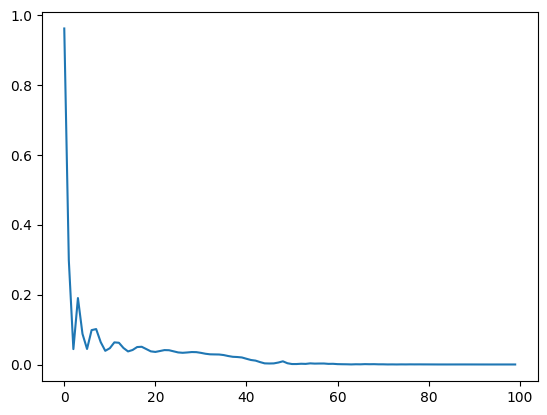

In [52]:
# Display training loss graph
plt.plot(hist, label="Training loss")

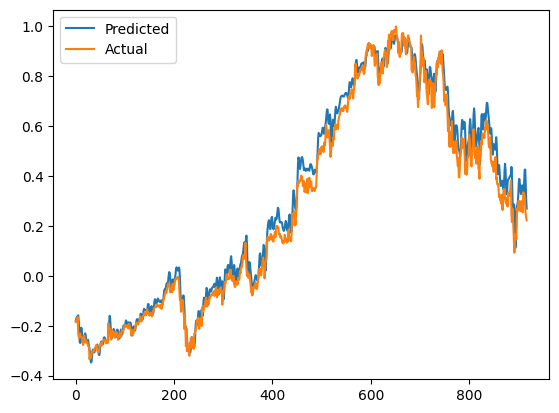

In [53]:
# Display stock price prediction vs data
y_test_pred = model(x_test)
plt.plot(y_test_pred.detach().numpy(), label="Predicted")
plt.plot(y_test_rnn.numpy(), label="Actual")
plt.legend()
plt.show()